# A greeting from Chenxi! This is a tutorial for the method introduced in our paper: "Nonmyopic Informative Path Planning Based on Global Kriging Variance Minimization." IEEE Robotics and Automation Letters (2022).



## Prerequisite: Install Dependencies (code has been tested on a Google colab GPU runtime)

In [1]:
!pip install tsp_solver2==0.4.1 # other versions might not be compatible.
!pip install gpytorch==1.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import gpytorch
import pickle
from tsp_solver.greedy import solve_tsp
from ippmpe import MPE_k, create_gpr,TSP,norm
import matplotlib.pyplot as plt

## 1.Read the map, and the previous observations


(1121, 2) (1121,)


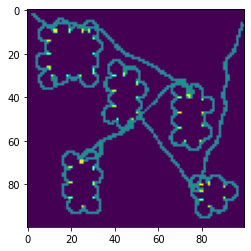

In [3]:
# 1. load the map
def load_map(filename):
    with open(filename, 'rb') as handle:
        a = pickle.load(handle)      
        return a["observe2d"], a["uncertainty2d"]

map_visited, init_uncertainty = load_map("observations.pickle")
plt.imshow(map_visited)

# 2. covert it to point cloud observations
X = np.argwhere(map_visited>-0.1)[:,[1,0]]
y = np.zeros(len(X))
print(X.shape, y.shape)


## 2. Create GP model to represent uncertainty, and do MPE sampling.

In [4]:
config = {
    "kernel_scale": 8,
    "kernel_noise": 0.0001,
}
gpr = create_gpr(X, y, config = config)
X,Y = np.meshgrid(np.arange(100),np.arange(100))
mesh = np.vstack([X.ravel()[None,:], Y.ravel()[None,:]]).T
mpe_samples = MPE_k(gpr, mesh, k=100)

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1685: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


## 3. solving TSP problem based on MPE landmarks

In [7]:
# add the initial location of the robot
init_pos = np.array([1,1])
landmarks = np.vstack([init_pos[None,:], mpe_samples])

# connectivity matrix. This could be simplified by a kNN version for a large scale problem.
D = np.zeros((len(landmarks), len(landmarks)))
for i in range(len(landmarks)):
    for j in range(len(landmarks)):
        D[i,j] = norm(landmarks[i]-landmarks[j])

# TSP solver
path = solve_tsp( D, endpoints=(0,None) )
print(path)

[0, 92, 73, 81, 53, 98, 21, 41, 12, 66, 93, 79, 78, 25, 58, 88, 33, 5, 63, 10, 61, 36, 83, 9, 45, 38, 18, 72, 3, 99, 23, 89, 49, 94, 60, 44, 67, 82, 32, 70, 39, 96, 56, 14, 90, 6, 24, 13, 97, 57, 2, 80, 20, 74, 34, 52, 16, 54, 86, 51, 19, 62, 42, 65, 15, 87, 28, 48, 35, 43, 84, 50, 30, 46, 7, 37, 64, 1, 40, 8, 22, 76, 77, 27, 71, 31, 100, 11, 55, 26, 29, 68, 4, 95, 59, 17, 47, 91, 69, 85, 75]


## 4. Visualization


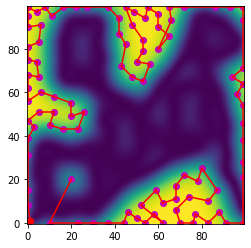

In [8]:
plt.imshow(init_uncertainty, origin='lower')
for i in range(len(path)-1):
    x1,y1 = landmarks[path[i]]
    x2,y2 = landmarks[path[i+1]]
    plt.plot([x1,x2],[y1,y2], c="r")
plt.scatter(landmarks[1:,0], landmarks[1:,1], c="m")
plt.scatter(landmarks[0,0], landmarks[0,1], c="r", s=40)
plt.show()